In [1]:
import os
import json
import pandas as pd
import seaborn as sns
from datetime import datetime
import numpy as np
import matplotlib.pylab as plt
#from Useful_Functions import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


In [4]:
SBA_Loan = pd.read_csv('SBAnational.csv', low_memory=False)
NAICS_DF = pd.read_csv('General Industry Codes.csv')
NAICS_DF = NAICS_DF.set_index('Code')

In [5]:
NAICS_DF

,IndustryName
Code,
11,"Agriculture, forestry, fishing and hunting"
21,"Mining, quarrying, and oil and gas extraction"
22,Utilities
23,Construction
31,Manufacturing
32,Manufacturing
33,Manufacturing
41,Wholesale trade
42,Wholesale trade


In [6]:
#----------------Overview of the Dataframe
#print(SBA_Loan.info())
print(SBA_Loan['NAICS'].value_counts()[0]/SBA_Loan.shape[0])   #about 22.5% of data do not have industry info, they can be removed for some questions
print(SBA_Loan['Term'].value_counts()[0]/SBA_Loan.shape[0])    #about 0.1% of data have 0 term, which makes no sense, since the term is in months, it is likely that the loan duration is less than 1 month (e.g., 1 week), in this case 0 should be round up to 1
print(SBA_Loan['State'].value_counts(dropna = False)[-1]/SBA_Loan.shape[0]) # only a few entries done have state info, we can drop them
print(SBA_Loan['Name'].value_counts(dropna = False)[-1]/SBA_Loan.shape[0]) # only a few entries done have name info, we can drop them
SBA_Loan = SBA_Loan[SBA_Loan['State'].notna()]
SBA_Loan = SBA_Loan[SBA_Loan['Name'].notna()]
SBA_Loan['Name'] = SBA_Loan['Name'].astype(str)

0.2245952907367288
0.0009008367772731115
1.557001837262168e-05
1.1121441694729772e-06


In [7]:
#Fill Missing values in the Industry Column
#step 1 Append General Industry to dataframe, and create a list of all states
No_missing_industry_df = SBA_Loan[SBA_Loan['NAICS'] != 0]
No_missing_industry_df['Industry'] = SBA_Loan['NAICS']
No_missing_industry_df['Industry'] = No_missing_industry_df['Industry'].apply(lambda x: industry_identifier(x,NAICS_DF))

States_list = No_missing_industry_df['State'].unique().tolist()


<ipython-input-7-ec52c39fc6c3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  No_missing_industry_df['Industry'] = SBA_Loan['NAICS']
<ipython-input-7-ec52c39fc6c3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  No_missing_industry_df['Industry'] = No_missing_industry_df['Industry'].apply(lambda x: industry_identifier(x,NAICS_DF))


In [8]:
No_missing_industry_df.head(100)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,Industry
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00",Retail trade
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00",Accommodation and food services
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,...,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00",Health care and social assistance
5,1000084002,"B&T SCREW MACHINE COMPANY, INC",PLAINVILLE,CT,6062,"TD BANK, NATIONAL ASSOCIATION",DE,332721,28-Feb-97,1997,...,N,NaN,30-Jun-97,"$517,000.00",$0.00,P I F,$0.00,"$517,000.00","$387,750.00",Manufacturing
7,1000094005,WEAVER PRODUCTS,SUMMERFIELD,FL,34491,REGIONS BANK,AL,811118,28-Feb-97,1997,...,Y,NaN,30-Jun-98,"$45,000.00",$0.00,P I F,$0.00,"$45,000.00","$36,000.00",Other services (except public administration)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,1001494009,THE SPORTS SECTION OF THE N.S.,NEWBURYPORT,MA,1950,DANVERSBANK,MA,541921,28-Feb-97,1997,...,Y,NaN,31-Mar-97,"$31,000.00",$0.00,P I F,$0.00,"$31,000.00","$24,800.00","Professional, scientific and technical services"
188,1001506002,TRIPLE J EXCAVATION,LAS CRUCES,NM,88012,COMPASS BANK,TX,238190,7-Feb-06,2006,...,N,NaN,28-Feb-06,"$50,000.00",$0.00,P I F,$0.00,"$50,000.00","$25,000.00",Construction
189,1001515009,"A. DeSousa, Inc.",Berkley,MA,2779,BANK OF AMERICA NATL ASSOC,NC,235510,8-Jul-97,1997,...,N,NaN,31-May-98,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$20,000.00",Construction
192,1001535004,Classic Plumbing & Heating Con,Cambridge,MA,2141,BANK OF AMERICA NATL ASSOC,NC,235110,10-Jul-97,1997,...,N,NaN,31-Oct-97,"$50,000.00",$0.00,P I F,$0.00,"$50,000.00","$25,000.00",Construction


In [9]:
States_list # ok

['IN',
 'CT',
 'FL',
 'NC',
 'IL',
 'OK',
 'AR',
 'MN',
 'CA',
 'SC',
 'TX',
 'LA',
 'IA',
 'TN',
 'MS',
 'OH',
 'MD',
 'VA',
 'MA',
 'PA',
 'OR',
 'ME',
 'KS',
 'MI',
 'AK',
 'WA',
 'CO',
 'WY',
 'UT',
 'MO',
 'AZ',
 'ID',
 'RI',
 'NJ',
 'NH',
 'NM',
 'NV',
 'NY',
 'ND',
 'VT',
 'WI',
 'MT',
 'AL',
 'GA',
 'KY',
 'NE',
 'WV',
 'SD',
 'DE',
 'DC',
 'HI']

In [12]:
#visuailization, looks like there is a wide distribution of industry in every state, explore other means to fill missing industry data
for state in States_list:
    plt.figure()
    df = No_missing_industry_df[No_missing_industry_df['State'] == state]
    ax = sns.countplot(x="Industry", data=df)
    plt.xticks(rotation='vertical')
    plt.title(state)
    # Show/save figure as desired.

#plt.show()

IndentationError: unexpected indent (<ipython-input-12-e313720983d2>, line 3)

In [13]:
#Alternatively, maybe the business name can be used to predict the industry that it is in, for example, if a company has 'manufacturing' in the name, it is probably in the manufacturing industry
print(No_missing_industry_df.info())
print(No_missing_industry_df['Name'])



<class 'pandas.core.frame.DataFrame'>
Int64Index: 697197 entries, 0 to 899161
Data columns (total 28 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   LoanNr_ChkDgt      697197 non-null  int64  
 1   Name               697197 non-null  object 
 2   City               697197 non-null  object 
 3   State              697197 non-null  object 
 4   Zip                697197 non-null  int64  
 5   Bank               696575 non-null  object 
 6   BankState          696572 non-null  object 
 7   NAICS              697197 non-null  int64  
 8   ApprovalDate       697197 non-null  object 
 9   ApprovalFY         697197 non-null  object 
 10  Term               697197 non-null  int64  
 11  NoEmp              697197 non-null  int64  
 12  NewExist           697061 non-null  float64
 13  CreateJob          697197 non-null  int64  
 14  RetainedJob        697197 non-null  int64  
 15  FranchiseCode      697197 non-null  int64  
 16  Ur

In [14]:
#step 1, split data set to train and test
No_missing_industry_df = No_missing_industry_df.set_index('LoanNr_ChkDgt')
train, test = train_test_split(No_missing_industry_df, test_size=0.2, random_state=0, stratify=No_missing_industry_df['Industry'])
print(train.shape[0])
print(test.shape[0])

557757
139440


,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,...,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,Industry
LoanNr_ChkDgt,,,,,,,,,,,,,,,,,,,,,
1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,84,...,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00",Retail trade
1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,60,...,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00",Accommodation and food services
1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,180,...,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00",Health care and social assistance
1000084002,"B&T SCREW MACHINE COMPANY, INC",PLAINVILLE,CT,6062,"TD BANK, NATIONAL ASSOCIATION",DE,332721,28-Feb-97,1997,120,...,N,NaN,30-Jun-97,"$517,000.00",$0.00,P I F,$0.00,"$517,000.00","$387,750.00",Manufacturing
1000094005,WEAVER PRODUCTS,SUMMERFIELD,FL,34491,REGIONS BANK,AL,811118,28-Feb-97,1997,84,...,Y,NaN,30-Jun-98,"$45,000.00",$0.00,P I F,$0.00,"$45,000.00","$36,000.00",Other services (except public administration)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995473009,"FABRICATORS STEEL, INC.",BALTIMORE,MD,21224,BANK OF AMERICA NATL ASSOC,MD,332431,27-Feb-97,1997,60,...,N,NaN,30-Jun-97,"$50,000.00",$0.00,P I F,$0.00,"$50,000.00","$25,000.00",Manufacturing
9995493004,PULLTARPS MFG.,EL CAJON,CA,92020,U.S. BANK NATIONAL ASSOCIATION,CA,314912,27-Feb-97,1997,36,...,N,NaN,31-Mar-97,"$200,000.00",$0.00,P I F,$0.00,"$200,000.00","$150,000.00",Manufacturing
9995573004,FABRIC FARMS,UPPER ARLINGTON,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,451120,27-Feb-97,1997,60,...,N,NaN,30-Sep-97,"$70,000.00",$0.00,P I F,$0.00,"$70,000.00","$56,000.00",Retail trade


In [15]:
#step 2, get the most common keywords that will be used as features for each industry
def find_n_most_common_words(df,industry,n=250):

    df = df.copy()
    df = df[df['Industry'] == industry]
    #parse name column to workable format
    df['Name'] = df['Name'].str.lower()
    df['Name'] = df['Name'].str.replace(',',' ')
    df['Name'] = df['Name'].str.replace('.',' ')
    df['Name'] = df['Name'].str.split(' ') #convert string to a list of words


    list_of_all_words = [item for sublist in df['Name'] for item in sublist]

    new_df = pd.DataFrame(list_of_all_words,columns = ['words'])
    new_df_groupped = new_df.groupby(['words'])['words'].count().sort_values(ascending = False)
    most_common_words = new_df_groupped.index.to_list()[0:n]

    return most_common_words
print(find_n_most_common_words(train,'Educational services')) #try this for Educations service industry, looks good
print(find_n_most_common_words(train,'Manufacturing')) #some makes sense, many are random

['', 'inc', 'llc', 'of', 'school', 'center', 'academy', 'learning', 'dance', 'the', '&', 'dba', 'arts', 'l', 'and', 'training', 'institute', 'a', 'gymnastics', 'martial', 'in', 'enterprises', 'driving', 'montessori', 'college', 'studio', 'services', 'music', 'education', 'huntington', 'c', 'sylvan', 'i', 'international', 'karate', 'educational', 'yoga', 'new', 'group', 'for', 'solutions', 'associates', 'consulting', 'art', 'tutoring', 'sports', 'j', 'computer', 'beauty', 'kids', 'american', 's', 'aviation', 'fitness', 'club', 'd', 'll', 'tae', 'language', 'career', 'm', 'corp', 'golf', 'do', 'professional', 'gym', 'to', 'elite', 'world', 'taekwondo', 'company', 'corporation', 'little', 'studios', 'ltd', 'california', 'cheer', 'systems', 'kwon', 'r', 'business', 'centers', 't', 'schools', 'young', 'health', 'technologies', 'e', 'usa', 'unlimited', 'service', 'technology', 'management', 'valley', 'co', 'all', 'massage', 'creative', 'development', 'south', 'advanced', 'on', 'real', 'unite

In [16]:
#Step 3, from step 2 there seems to be a lot of overlapping words between different industries, the next step would be eliminating the overlapping words
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3



list_of_words= find_n_most_common_words(train,'Manufacturing')
list_of_industry = train['Industry'].unique()

for industry in list_of_industry:
    industry_words = find_n_most_common_words(train,industry)
    list_of_words = intersection(industry_words,list_of_words)

print(list_of_words)  #['', 'inc', 'llc', 'l', '&', 'c', 'corp', 'enterprises', 'management', 'associates', 'j', 'and', 'r', 'group', 'the', 'of', 'm', 'co', 'company', 'd', 'a', 'in', 'g', 'p', 'i', 'corporation', 's', 'w', 'services', 'american', 'dba', 'service'] is the overlapping words, so remove them from the list of most used words



['', 'inc', 'llc', 'services', '&', 'c', 'dba', 'l', 'j', 'of', 'a', 'm', 'the', 'd', 'p', 'co', 'enterprises', 'r', 'corp', 'and', 'g', 'corporation', 's']


In [25]:
y_train = pd.Series(np.array(train['Industry']=='Manufacturing')).astype(int)
y_train

0         0
1         0
2         0
3         1
4         1
         ..
557752    0
557753    0
557754    0
557755    0
557756    0
Length: 557757, dtype: int32

In [31]:
def industry_identifier(code,NAICS_DF):
    industry_name = 'Undefined'
    first_two_digits = int(str(code)[:2])
    if first_two_digits in NAICS_DF.index.values:
        if code != 0:
           industry_name = NAICS_DF.loc[first_two_digits, 'IndustryName']

    return industry_name

def merge_on_date(df_A, df_B, df_A_column, df_B_column):
    for index, row in df_B.iterrows():
        start_date = row['start date']
        end_date = row['end date']
        for index1, row1 in df_A.iterrows():
            if row1['ApprovalDate'] < end_date and row1['ApprovalDate'] >= start_date:
                df_A.at[index1, df_A_column] = row[df_B_column]

    return df_A

def fix_year(series_A, series_B):
    empty_list = []
    for index, value in enumerate(series_A):
        k = value.replace(year = int(series_B[index]))
        empty_list.append(k)
    series_A = empty_list
    return series_A

def clean_currency(x):
    """ If the value is a string, then remove currency symbol and delimiters
    otherwise, the value is numeric and can be converted
    """
    if isinstance(x, str):
        return x.replace('$', '').replace(',', '')
    return x


def precision(y_true, y_pred):
    """
    Returns the precision score.

    Parameters:
        y_true (1D numpy array): 1D array of true binary labels
                                 np.array([0, 1, 0, 0, ..]).
        y_pred (1D numpy array): 1D array of predicted binary labels
                                 np.array([1, 0, 0, 1, ..]).

    Returns:
        (float): The precision.
    """

    # Write your code here
    try:
        return count_true_positives(y_true, y_pred) / (
                    count_true_positives(y_true, y_pred) + count_false_positives(y_true, y_pred))
    except ZeroDivisionError:
        return 0

def accuracy(y_true, y_pred):

    """
    Copied from Assignment 8
    Returns a accuracy score for two 1D numpy array of the same length.

    Parameters:
        y_true (1D numpy array): 1D array of true binary labels
                                 np.array([0, 1, 0, 0, ..]).
        y_pred (1D numpy array): 1D array of predicted binary labels
                                 np.array([1, 0, 0, 1, ..]).

    Returns:
        (float): Accuracy score of y_true and y_pred.
    """

    # Write your code here
    TP_plus_TN = 0
    for i in range(len(y_true)):
        if y_true[i] - y_pred[i] == 0:
            TP_plus_TN +=1

    accuracy_score = TP_plus_TN/len(y_true)
    return accuracy_score

def recall(y_true, y_pred):
    """
    Returns the recall score.

    Parameters:
        y_true (1D numpy array): 1D array of true binary labels
                                 np.array([0, 1, 0, 0, ..]).
        y_pred (1D numpy array): 1D array of predicted binary labels
                                 np.array([1, 0, 0, 1, ..]).

    Returns:
        (float): The recall.
    """

    # Write your code here
    recall_score = count_true_positives(y_true, y_pred) / (count_true_positives(y_true, y_pred) + count_false_negatives(y_true, y_pred))

    return recall_score


def false_alarm_rate(y_true, y_pred):
    """
    Returns the false alarm rate.

    Parameters:
        y_true (1D numpy array): 1D array of true binary labels
                                 np.array([0, 1, 0, 0, ..]).
        y_pred (1D numpy array): 1D array of predicted binary labels
                                 np.array([1, 0, 0, 1, ..]).

    Returns:
        (float): The false positive rate.
    """

    # Write your code here
    false_alarm_score = count_false_positives(y_true, y_pred) / (count_false_positives(y_true, y_pred) + count_true_negatives(y_true, y_pred))

    return false_alarm_score


def f_beta(y_true, y_pred, beta):
    """
    Returns the F-beta score.

    Parameters:
        y_true (1D numpy array): 1D array of true binary labels
                                 np.array([0, 1, 0, 0, ..]).
        y_pred (1D numpy array): 1D array of predicted binary labels
                                 np.array([1, 0, 0, 1, ..]).
        beta (float): The beta parameter for the F-beta metric.

    Returns:
        (float): The F-beta score.
    """


    try:
        return (1 + beta ** 2) * precision(y_true, y_pred) * recall(y_true, y_pred) / (beta ** 2 * precision(y_true, y_pred) + recall(y_true, y_pred))
    except ZeroDivisionError:
        return 0


def count_false_positives(y_true, y_pred):
    """
    Returns the number of false positives.

    Parameters:
        y_true (1D numpy array): 1D array of true binary labels
                                 np.array([0, 1, 0, 0, ..]).
        y_pred (1D numpy array): 1D array of predicted binary labels
                                 np.array([1, 0, 0, 1, ..]).

    Returns:
        (int): The number of false positives detected.
    """

    FP = 0
    for i in range(len(y_true)):
        if y_true[i] - y_pred[i] == -1:
            if y_true[i] == 0:
                FP += 1

    return FP


def count_false_negatives(y_true, y_pred):
    """
    Returns the number of false negatives.

    Parameters:
        y_true (1D numpy array): 1D array of true binary labels
                                 np.array([0, 1, 0, 0, ..]).
        y_pred (1D numpy array): 1D array of predicted binary labels
                                 np.array([1, 0, 0, 1, ..]).

    Returns:
        (int): The number of false negatives detected.
    """

    FN = 0
    for i in range(len(y_true)):
        if (y_true[i] - y_pred[i] == 1) and (y_true[i] == 1):
            FN += 1

    return FN


def count_true_positives(y_true, y_pred):
    """
    Returns the number of true positives.

    Parameters:
        y_true (1D numpy array): 1D array of true binary labels
                                 np.array([0, 1, 0, 0, ..]).
        y_pred (1D numpy array): 1D array of predicted binary labels
                                 np.array([1, 0, 0, 1, ..]).

    Returns:
        (int): The number of true positives detected.
    """

    # Write your code here
    TP = 0
    for i in range(len(y_true)):
        if (y_true[i] - y_pred[i] == 0) and (y_true[i] == 1):
            TP += 1

    return TP


def count_true_negatives(y_true, y_pred):
    """
    Returns the number of false negatives.

    Parameters:
        y_true (1D numpy array): 1D array of true binary labels
                                 np.array([0, 1, 0, 0, ..]).
        y_pred (1D numpy array): 1D array of predicted binary labels
                                 np.array([1, 0, 0, 1, ..]).

    Returns:
        (int): The number of true negatives detected.
    """

    # Write your code here
    TN = 0
    for i in range(len(y_true)):
        if (y_true[i] - y_pred[i] == 0) and (y_true[i] == 0):
            TN += 1

    return TN

def word_detector(words, texts):

    """
    Copied from Assignment 8
    Returns a DataFrame with detections of words.

    Parameters:
        words (list): A list of words to look for.
        texts (Series): A series of strings to search in.

    Returns:
        (DataFrame): A DataFrame with len(words) columns and texts.shape[0] rows.
    """


    row_to_df = []
    for index, value in texts.items():
        row = [0]*len(words)
        for y in range(len(words)):
            n = 0
            if words[y] in value.lower():
                n = 1
            row[y] = n
        row_to_df.append(row)
    df = pd.DataFrame(row_to_df,columns=words)
    df = df.set_index(texts.index)
    return df

In [62]:
Missing_industry_df = SBA_Loan[SBA_Loan['NAICS'] == 0]
#Missing_industry_df['Industry'] = No_missing_industry_df['Industry'].apply(lambda x: industry_identifier(x,NAICS_DF))
Missing_industry_df['Industry'] = 0
Missing_industry_df['Industry'] = result_array

Missing_industry_df = Missing_industry_df[Missing_industry_df['Industry'] == '0']
Missing_industry_df

<ipython-input-62-3aada4e241b9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Missing_industry_df['Industry'] = 0
<ipython-input-62-3aada4e241b9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Missing_industry_df['Industry'] = result_array


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,Industry
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,...,Y,NaN,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00",0
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,...,N,NaN,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00",0
6,1000093009,MIDDLE ATLANTIC SPORTS CO INC,UNION,NJ,7083,WELLS FARGO BANK NATL ASSOC,SD,0,2-Jun-80,1980,...,N,24-Jun-91,22-Jul-80,"$600,000.00",$0.00,CHGOFF,"$208,959.00","$600,000.00","$499,998.00",0
9,1000124001,INTEXT BUILDING SYS LLC,GLASTONBURY,CT,6073,WEBSTER BANK NATL ASSOC,CT,0,28-Feb-97,1997,...,Y,NaN,30-Apr-97,"$70,000.00",$0.00,P I F,$0.00,"$70,000.00","$56,000.00",0
13,1000154010,"ORCHARD CAFE & BAKERY, INC.",SLATERSVILLE,RI,2876,CITIZENS BANK NATL ASSOC,RI,0,28-Feb-97,1997,...,N,NaN,31-May-97,"$370,000.00",$0.00,P I F,$0.00,"$370,000.00","$277,500.00",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899153,9995413002,NORTH SHORE FLORAL,WOODBURY,NY,11797,FLUSHING BANK,NY,0,27-Feb-97,1997,...,N,7-Jul-04,31-May-97,"$142,000.00",$0.00,CHGOFF,$0.00,"$142,000.00","$106,500.00",0
899154,9995423005,"LITWIN LIVERY SERVICES, INC.",CAMPBELL,OH,44405,JPMORGAN CHASE BANK NATL ASSOC,IL,0,27-Feb-97,1997,...,N,NaN,30-Sep-97,"$10,000.00",$0.00,P I F,$0.00,"$10,000.00","$5,000.00",0
899158,9995563001,SHADES WINDOW TINTING AUTO ALA,IRVING,TX,75062,LOANS FROM OLD CLOSED LENDERS,DC,0,27-Feb-97,1997,...,Y,NaN,30-Jun-97,"$79,000.00",$0.00,P I F,$0.00,"$79,000.00","$63,200.00",0
899162,9995973006,"MARUTAMA HAWAII, INC.",HONOLULU,HI,96830,BANK OF HAWAII,HI,0,27-Feb-97,1997,...,Y,8-Mar-00,31-Mar-97,"$75,000.00",$0.00,CHGOFF,"$46,383.00","$75,000.00","$60,000.00",0


In [67]:
#Step 4 Train 20 models to predict industry
iteration = 1
for industry in list_of_industry:
    industry_name_words = find_n_most_common_words(train,industry)
    industry_name_words_revised = [item for item in industry_name_words if item not in list_of_words]#filter out the overlapping words
    industry_name_words_revised = [item for item in industry_name_words_revised if len(item)>1] #filter out words that has only 1 character
    x_train = word_detector(industry_name_words_revised,train['Name'])
    y_train = pd.Series(np.array(train['Industry']==industry)).astype(int)
    model = LogisticRegression(solver='liblinear', random_state=0)
    model = model.fit(x_train,y_train)
    x_predict = word_detector(industry_name_words_revised,Missing_industry_df['Name'])
    y_predict = model.predict(x_predict)
    y_predict_proba = model.predict_proba(x_predict)[:,1]
    #result_array = np.where(y_predict == 1, industry, y_predict)
    Missing_industry_df[industry] = y_predict_proba
    #Missing_industry_df = Missing_industry_df[Missing_industry_df['Industry'] == '0']
    #print(result_array)
    #Missing_industry_df
    #print(false_alarm_rate(y_train,y_predict))  #false alarm rate ranges from 0 to about 2%, not bad

    print(iteration)
    iteration = iteration + 1
#industry_name_words = find_n_most_common_words(train,'Manufacturing')
#industry_name_words_revised = [item for item in industry_name_words if item not in list_of_words] #filter out the overlapping words
#industry_name_words_revised = [item for item in industry_name_words_revised if len(item)>1] #further filter out words that has only 1 character
#x_train = word_detector(industry_name_words_revised,train['Name'])
#y_train = pd.Series(np.array(train['Industry']=='Manufacturing')).astype(int)
#train_industry_df= pd.concat((x_train,y_train), axis=1)
#model = LogisticRegression(solver='liblinear', random_state=0)
#model = model.fit(x_train, y_train)
#y_predict_prob = model.predict_proba(x_train)[:,1]
#y_pred = np.where(y_predict_prob > 0.35, 1, 0)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


In [107]:
Missing_industry_df
Missing_industry_df_copy = Missing_industry_df.copy()
threshold = 0.35


In [108]:
Missing_industry_df_copy['Industry'] = Missing_industry_df_copy[list_of_industry].max(axis=1)
Missing_industry_df_copy = Missing_industry_df_copy[Missing_industry_df_copy['Industry'] >= threshold]
print(max_proba)
Missing_industry_df_copy

        probability
3          0.665081
13         0.770393
17         0.967508
18         0.914018
19         0.351076
...             ...
899134     0.908748
899148     0.950088
899153     0.888966
899158     0.442537
899163     0.518129

[102349 rows x 1 columns]


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,Transportation and warehousing,Accommodation and food services,"Administrative and support, waste management and remediation services",Wholesale trade,Finance and insurance,Educational services,"Mining, quarrying, and oil and gas extraction",Utilities,Management of companies and enterprises,Public administration
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,...,0.019135,0.110384,0.021391,0.092919,0.377260,0.005359,0.001902,0.000428,0.000360,0.000288
13,1000154010,"ORCHARD CAFE & BAKERY, INC.",SLATERSVILLE,RI,2876,CITIZENS BANK NATL ASSOC,RI,0,28-Feb-97,1997,...,0.011753,0.770393,0.019980,0.058597,0.003287,0.003560,0.001043,0.000413,0.000215,0.000193
17,1000264008,"FAIRFAX COURT SUBWAY, INC.",CENTREVILLE,VA,20120,BANK OF AMERICA NATL ASSOC,MD,0,28-Feb-97,1997,...,0.017693,0.967508,0.008815,0.047741,0.003287,0.003560,0.001043,0.000863,0.000215,0.000612
18,1000284003,FANTASTIC SAMS,PLANO,TX,75093,NEWTEK SMALL BUS. FINANCE INC.,NY,0,28-Feb-97,1997,...,0.013406,0.035434,0.018651,0.042835,0.003955,0.003508,0.000717,0.000414,0.000212,0.000176
19,1000294006,SIR GOONY'S GOLF,KNOXVILLE,TN,37922,CITIZENS NATIONAL BANK,TN,0,28-Feb-97,1997,...,0.008525,0.051553,0.020771,0.049254,0.003433,0.011170,0.000717,0.000414,0.000215,0.000193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899134,9995083010,RUSHING'S GROCERY,LAURINBURG,NC,28352,WELLS FARGO BANK NATL ASSOC,SD,0,27-Feb-97,1997,...,0.011452,0.042792,0.019980,0.056197,0.003304,0.003790,0.001043,0.000413,0.000215,0.000695
899148,9995353008,FRANKIE'S CHICAGO STYLE PIZZA,MAPLE GROVE,MN,55369,WELLS FARGO BANK NATL ASSOC,SD,0,27-Feb-97,1997,...,0.026963,0.950088,0.018651,0.037545,0.010554,0.003508,0.000717,0.000375,0.000212,0.000193
899153,9995413002,NORTH SHORE FLORAL,WOODBURY,NY,11797,FLUSHING BANK,NY,0,27-Feb-97,1997,...,0.012872,0.048914,0.022530,0.053535,0.003192,0.004572,0.000717,0.001023,0.000801,0.000193
899158,9995563001,SHADES WINDOW TINTING AUTO ALA,IRVING,TX,75062,LOANS FROM OLD CLOSED LENDERS,DC,0,27-Feb-97,1997,...,0.003946,0.017558,0.028539,0.023049,0.001275,0.002920,0.001043,0.000244,0.000215,0.000193


In [113]:
Probability_df = Missing_industry_df_copy[list_of_industry]
Missing_industry_df_copy['Industry'] = Probability_df.apply(lambda x: Probability_df.columns[x.argmax()], axis = 1)
print(Missing_industry_df_copy.shape[0])
Missing_industry_df_copy #used text analysis to fill in the industry info for 102349 rows


102349


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,Transportation and warehousing,Accommodation and food services,"Administrative and support, waste management and remediation services",Wholesale trade,Finance and insurance,Educational services,"Mining, quarrying, and oil and gas extraction",Utilities,Management of companies and enterprises,Public administration
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,...,0.019135,0.110384,0.021391,0.092919,0.377260,0.005359,0.001902,0.000428,0.000360,0.000288
13,1000154010,"ORCHARD CAFE & BAKERY, INC.",SLATERSVILLE,RI,2876,CITIZENS BANK NATL ASSOC,RI,0,28-Feb-97,1997,...,0.011753,0.770393,0.019980,0.058597,0.003287,0.003560,0.001043,0.000413,0.000215,0.000193
17,1000264008,"FAIRFAX COURT SUBWAY, INC.",CENTREVILLE,VA,20120,BANK OF AMERICA NATL ASSOC,MD,0,28-Feb-97,1997,...,0.017693,0.967508,0.008815,0.047741,0.003287,0.003560,0.001043,0.000863,0.000215,0.000612
18,1000284003,FANTASTIC SAMS,PLANO,TX,75093,NEWTEK SMALL BUS. FINANCE INC.,NY,0,28-Feb-97,1997,...,0.013406,0.035434,0.018651,0.042835,0.003955,0.003508,0.000717,0.000414,0.000212,0.000176
19,1000294006,SIR GOONY'S GOLF,KNOXVILLE,TN,37922,CITIZENS NATIONAL BANK,TN,0,28-Feb-97,1997,...,0.008525,0.051553,0.020771,0.049254,0.003433,0.011170,0.000717,0.000414,0.000215,0.000193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899134,9995083010,RUSHING'S GROCERY,LAURINBURG,NC,28352,WELLS FARGO BANK NATL ASSOC,SD,0,27-Feb-97,1997,...,0.011452,0.042792,0.019980,0.056197,0.003304,0.003790,0.001043,0.000413,0.000215,0.000695
899148,9995353008,FRANKIE'S CHICAGO STYLE PIZZA,MAPLE GROVE,MN,55369,WELLS FARGO BANK NATL ASSOC,SD,0,27-Feb-97,1997,...,0.026963,0.950088,0.018651,0.037545,0.010554,0.003508,0.000717,0.000375,0.000212,0.000193
899153,9995413002,NORTH SHORE FLORAL,WOODBURY,NY,11797,FLUSHING BANK,NY,0,27-Feb-97,1997,...,0.012872,0.048914,0.022530,0.053535,0.003192,0.004572,0.000717,0.001023,0.000801,0.000193
899158,9995563001,SHADES WINDOW TINTING AUTO ALA,IRVING,TX,75062,LOANS FROM OLD CLOSED LENDERS,DC,0,27-Feb-97,1997,...,0.003946,0.017558,0.028539,0.023049,0.001275,0.002920,0.001043,0.000244,0.000215,0.000193


In [122]:
Missing_industry_df_copy = Missing_industry_df_copy.drop(columns = list_of_industry)
Missing_industry_df_copy

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,Industry
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,...,Y,NaN,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00",Retail trade
13,1000154010,"ORCHARD CAFE & BAKERY, INC.",SLATERSVILLE,RI,2876,CITIZENS BANK NATL ASSOC,RI,0,28-Feb-97,1997,...,N,NaN,31-May-97,"$370,000.00",$0.00,P I F,$0.00,"$370,000.00","$277,500.00",Accommodation and food services
17,1000264008,"FAIRFAX COURT SUBWAY, INC.",CENTREVILLE,VA,20120,BANK OF AMERICA NATL ASSOC,MD,0,28-Feb-97,1997,...,Y,NaN,31-Jul-97,"$100,000.00",$0.00,P I F,$0.00,"$100,000.00","$80,000.00",Accommodation and food services
18,1000284003,FANTASTIC SAMS,PLANO,TX,75093,NEWTEK SMALL BUS. FINANCE INC.,NY,0,28-Feb-97,1997,...,Y,NaN,31-May-97,"$57,500.00",$0.00,P I F,$0.00,"$57,500.00","$46,000.00",Other services (except public administration)
19,1000294006,SIR GOONY'S GOLF,KNOXVILLE,TN,37922,CITIZENS NATIONAL BANK,TN,0,28-Feb-97,1997,...,Y,NaN,31-May-98,"$50,000.00",$0.00,P I F,$0.00,"$50,000.00","$40,000.00",Retail trade
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899134,9995083010,RUSHING'S GROCERY,LAURINBURG,NC,28352,WELLS FARGO BANK NATL ASSOC,SD,0,27-Feb-97,1997,...,N,NaN,31-Mar-97,"$25,455.00",$0.00,P I F,$0.00,"$20,000.00","$10,000.00",Retail trade
899148,9995353008,FRANKIE'S CHICAGO STYLE PIZZA,MAPLE GROVE,MN,55369,WELLS FARGO BANK NATL ASSOC,SD,0,27-Feb-97,1997,...,N,NaN,31-Mar-97,"$100,000.00",$0.00,P I F,$0.00,"$100,000.00","$80,000.00",Accommodation and food services
899153,9995413002,NORTH SHORE FLORAL,WOODBURY,NY,11797,FLUSHING BANK,NY,0,27-Feb-97,1997,...,N,7-Jul-04,31-May-97,"$142,000.00",$0.00,CHGOFF,$0.00,"$142,000.00","$106,500.00",Retail trade
899158,9995563001,SHADES WINDOW TINTING AUTO ALA,IRVING,TX,75062,LOANS FROM OLD CLOSED LENDERS,DC,0,27-Feb-97,1997,...,Y,NaN,30-Jun-97,"$79,000.00",$0.00,P I F,$0.00,"$79,000.00","$63,200.00",Other services (except public administration)


In [118]:
No_missing_industry_df = No_missing_industry_df.reset_index(drop = False)
No_missing_industry_df

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,Industry
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00",Retail trade
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00",Accommodation and food services
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,...,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00",Health care and social assistance
3,1000084002,"B&T SCREW MACHINE COMPANY, INC",PLAINVILLE,CT,6062,"TD BANK, NATIONAL ASSOCIATION",DE,332721,28-Feb-97,1997,...,N,NaN,30-Jun-97,"$517,000.00",$0.00,P I F,$0.00,"$517,000.00","$387,750.00",Manufacturing
4,1000094005,WEAVER PRODUCTS,SUMMERFIELD,FL,34491,REGIONS BANK,AL,811118,28-Feb-97,1997,...,Y,NaN,30-Jun-98,"$45,000.00",$0.00,P I F,$0.00,"$45,000.00","$36,000.00",Other services (except public administration)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697192,9995473009,"FABRICATORS STEEL, INC.",BALTIMORE,MD,21224,BANK OF AMERICA NATL ASSOC,MD,332431,27-Feb-97,1997,...,N,NaN,30-Jun-97,"$50,000.00",$0.00,P I F,$0.00,"$50,000.00","$25,000.00",Manufacturing
697193,9995493004,PULLTARPS MFG.,EL CAJON,CA,92020,U.S. BANK NATIONAL ASSOCIATION,CA,314912,27-Feb-97,1997,...,N,NaN,31-Mar-97,"$200,000.00",$0.00,P I F,$0.00,"$200,000.00","$150,000.00",Manufacturing
697194,9995573004,FABRIC FARMS,UPPER ARLINGTON,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,451120,27-Feb-97,1997,...,N,NaN,30-Sep-97,"$70,000.00",$0.00,P I F,$0.00,"$70,000.00","$56,000.00",Retail trade
697195,9995603000,FABRIC FARMS,COLUMBUS,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,451130,27-Feb-97,1997,...,N,NaN,31-Oct-97,"$85,000.00",$0.00,P I F,$0.00,"$85,000.00","$42,500.00",Retail trade


In [127]:
#Concatenante the dataframes, the total row number is 799546, which is 88.9% of the original dataset. Missing industry data went from 22.5% to 11%
frames = [No_missing_industry_df, Missing_industry_df_copy]
merged_df = pd.concat(frames)
merged_df


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,Industry
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00",Retail trade
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00",Accommodation and food services
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,...,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00",Health care and social assistance
3,1000084002,"B&T SCREW MACHINE COMPANY, INC",PLAINVILLE,CT,6062,"TD BANK, NATIONAL ASSOCIATION",DE,332721,28-Feb-97,1997,...,N,NaN,30-Jun-97,"$517,000.00",$0.00,P I F,$0.00,"$517,000.00","$387,750.00",Manufacturing
4,1000094005,WEAVER PRODUCTS,SUMMERFIELD,FL,34491,REGIONS BANK,AL,811118,28-Feb-97,1997,...,Y,NaN,30-Jun-98,"$45,000.00",$0.00,P I F,$0.00,"$45,000.00","$36,000.00",Other services (except public administration)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899134,9995083010,RUSHING'S GROCERY,LAURINBURG,NC,28352,WELLS FARGO BANK NATL ASSOC,SD,0,27-Feb-97,1997,...,N,NaN,31-Mar-97,"$25,455.00",$0.00,P I F,$0.00,"$20,000.00","$10,000.00",Retail trade
899148,9995353008,FRANKIE'S CHICAGO STYLE PIZZA,MAPLE GROVE,MN,55369,WELLS FARGO BANK NATL ASSOC,SD,0,27-Feb-97,1997,...,N,NaN,31-Mar-97,"$100,000.00",$0.00,P I F,$0.00,"$100,000.00","$80,000.00",Accommodation and food services
899153,9995413002,NORTH SHORE FLORAL,WOODBURY,NY,11797,FLUSHING BANK,NY,0,27-Feb-97,1997,...,N,7-Jul-04,31-May-97,"$142,000.00",$0.00,CHGOFF,$0.00,"$142,000.00","$106,500.00",Retail trade
899158,9995563001,SHADES WINDOW TINTING AUTO ALA,IRVING,TX,75062,LOANS FROM OLD CLOSED LENDERS,DC,0,27-Feb-97,1997,...,Y,NaN,30-Jun-97,"$79,000.00",$0.00,P I F,$0.00,"$79,000.00","$63,200.00",Other services (except public administration)


In [128]:
merged_df.to_csv('SBAnational_with_industry_added.csv')


Data Cleaning: Add Rural and Urban Info

In [4]:
merged_df = pd.read_csv('SBAnational_with_industry_added.csv')
urbanruralzip = pd.read_csv('UrbanRuralZipcodes.csv')

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
merged_df

,Unnamed: 0,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,...,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,Industry
0,0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,...,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00",Retail trade
1,1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,...,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00",Accommodation and food services
2,2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,...,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00",Health care and social assistance
3,3,1000084002,"B&T SCREW MACHINE COMPANY, INC",PLAINVILLE,CT,6062,"TD BANK, NATIONAL ASSOCIATION",DE,332721,28-Feb-97,...,N,NaN,30-Jun-97,"$517,000.00",$0.00,P I F,$0.00,"$517,000.00","$387,750.00",Manufacturing
4,4,1000094005,WEAVER PRODUCTS,SUMMERFIELD,FL,34491,REGIONS BANK,AL,811118,28-Feb-97,...,Y,NaN,30-Jun-98,"$45,000.00",$0.00,P I F,$0.00,"$45,000.00","$36,000.00",Other services (except public administration)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799541,899134,9995083010,RUSHING'S GROCERY,LAURINBURG,NC,28352,WELLS FARGO BANK NATL ASSOC,SD,0,27-Feb-97,...,N,NaN,31-Mar-97,"$25,455.00",$0.00,P I F,$0.00,"$20,000.00","$10,000.00",Retail trade
799542,899148,9995353008,FRANKIE'S CHICAGO STYLE PIZZA,MAPLE GROVE,MN,55369,WELLS FARGO BANK NATL ASSOC,SD,0,27-Feb-97,...,N,NaN,31-Mar-97,"$100,000.00",$0.00,P I F,$0.00,"$100,000.00","$80,000.00",Accommodation and food services
799543,899153,9995413002,NORTH SHORE FLORAL,WOODBURY,NY,11797,FLUSHING BANK,NY,0,27-Feb-97,...,N,7-Jul-04,31-May-97,"$142,000.00",$0.00,CHGOFF,$0.00,"$142,000.00","$106,500.00",Retail trade
799544,899158,9995563001,SHADES WINDOW TINTING AUTO ALA,IRVING,TX,75062,LOANS FROM OLD CLOSED LENDERS,DC,0,27-Feb-97,...,Y,NaN,30-Jun-97,"$79,000.00",$0.00,P I F,$0.00,"$79,000.00","$63,200.00",Other services (except public administration)


In [6]:
urbanruralzip_for_merge = urbanruralzip[['zip','migmet']]
urbanruralzip_for_merge

,zip,migmet
0,1001,100.0
1,1002,100.0
2,1005,100.0
3,1007,100.0
4,1008,100.0
...,...,...
31738,99925,0.0
31739,99926,0.0
31740,99927,0.0
31741,99929,0.0


In [20]:
merged_with_urban = merged_df.merge(urbanruralzip_for_merge, how='left', left_on = 'Zip', right_on = 'zip')
merged_with_urban = merged_with_urban.drop(['zip'], axis=1)
merged_with_urban.rename(columns = {'migmet':'UrbanWorkerPercentage'}, inplace = True)
urban_df = merged_with_urban.groupby(['UrbanRural']).agg({'UrbanWorkerPercentage': ['mean','count','max','min']})
urban_df = urban_df.reset_index()
urban_df['UrbanRural'] = urban_df['UrbanRural'].apply(lambda x: 'Undefined' if x == 0 else x).apply(lambda x: 'Urban' if x == 1 else x).apply(lambda x: 'Rural' if x == 2 else x)
urban_df

UrbanRural UrbanWorkerPercentage                    
                              mean   count    max  min
0  Undefined             82.845330  224721  100.0  0.0
1      Urban             95.519891  449267  100.0  0.0
2      Rural             62.877542  100919  100.0  0.0

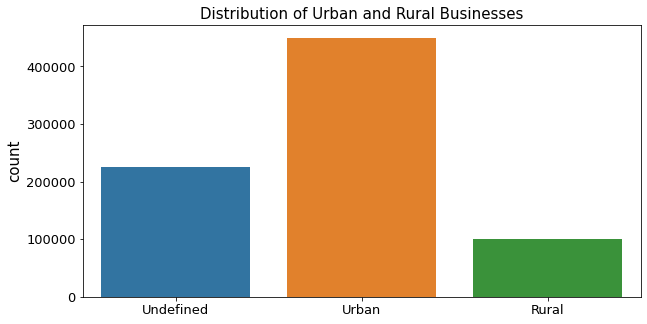

In [37]:
plt.figure(figsize=(10,5))
plt.title('Distribution of Urban and Rural Businesses', fontsize = 15)
y = urban_df['UrbanWorkerPercentage']['count']
ax3 = sns.barplot(x = 'UrbanRural',y = y,data = urban_df)
plt.xlabel('', fontsize=15)
plt.ylabel('count', fontsize=15)
plt.xticks(fontsize= 13)
plt.yticks(fontsize= 13)
plt.savefig('Distribution of Urban and Rural Businesses')
